In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
# import AllTogether as t
import seaborn as sns
import decimal
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_csv('data/listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [2]:
df["amenities"]

0       {TV,"Cable TV",Internet,"Wireless Internet","A...
1       {TV,Internet,"Wireless Internet",Kitchen,"Free...
2       {TV,"Cable TV",Internet,"Wireless Internet","A...
3       {Internet,"Wireless Internet",Kitchen,"Indoor ...
4       {TV,"Cable TV",Internet,"Wireless Internet",Ki...
                              ...                        
3813    {TV,"Cable TV",Internet,"Wireless Internet","A...
3814    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
3815    {"Cable TV","Wireless Internet",Kitchen,"Free ...
3816    {TV,"Wireless Internet",Kitchen,"Free Parking ...
3817    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, Length: 3818, dtype: object

In [3]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

In [4]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [5]:
def clean_data(df, testName, dropColList):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    # cleanse monetary
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    df['weekly_price'] = df['weekly_price'].replace('[\$,]', '', regex=True).astype(float)
    df['monthly_price'] = df['monthly_price'].replace('[\$,]', '', regex=True).astype(float)
    df['security_deposit'] = df['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
    df['cleaning_fee'] = df['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
    df['extra_people'] = df['extra_people'].replace('[\$,]', '', regex=True).astype(float)
    
    # Drop rows with missing salary values
    df = df.dropna(subset=[testName], axis=0)
    
    # Get test answers
    y = df[testName]
    
    #Drop columns
    df = df.drop(dropColList, axis=1)

    # cleanse percentages
    df['host_response_rate'] = df['host_response_rate'].replace('[\%]', '', regex=True).astype(float)
    df['host_acceptance_rate'] = df['host_acceptance_rate'].replace('[\%]', '', regex=True).astype(float)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y


In [6]:
drop_col_list1 = ['price', 'weekly_price', 'monthly_price', 'id', 'scrape_id', 'host_id', 
                  'listing_url', 'last_scraped', 'summary', 
                  'space', 'description', 'name', 'notes', 'transit', 
                  'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 
                  'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 
                  'host_picture_url', 'host_neighbourhood', 'neighbourhood', 'calendar_last_scraped', 
                  'experiences_offered', 'neighborhood_overview', 'smart_location', 
                  'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 
                  'longitude', 'zipcode', 'city', 'jurisdiction_names', 'calculated_host_listings_count', 
                  'host_listings_count', 'street']

drop_col_list2 = ['price', 'weekly_price', 'monthly_price', 'id', 'scrape_id', 'host_id', 
                  'listing_url', 'last_scraped', 'summary', 
                  'space', 'description', 'name', 'notes', 'transit', 
                  'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 
                  'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 
                  'host_picture_url', 'host_neighbourhood', 'neighbourhood', 'calendar_last_scraped', 
                  'experiences_offered', 'neighborhood_overview', 'smart_location', 
                  'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 
                  'longitude', 'zipcode', 'city', 'jurisdiction_names', 'calculated_host_listings_count', 
                  'host_listings_count']

#Use the function to create X and y
X_price, y_price = clean_data(df, 'price', drop_col_list1)
X_weekly, y_weekly = clean_data(df, 'weekly_price', drop_col_list1)
X_monthly, y_monthly = clean_data(df, 'monthly_price', drop_col_list1)

price prediction


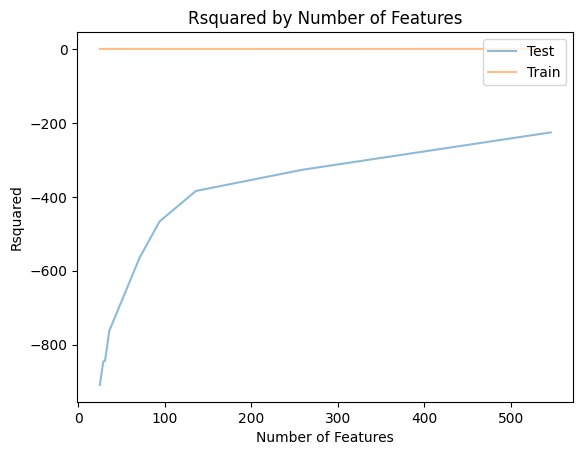

546
-225.37458930972903
0.6909077887639883


In [7]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 25, 10, 5]

print("price prediction")

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X_price, y_price, cutoffs)

print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2


In [8]:
coef_df_price = coef_weights(lm_model.coef_, X_train)

coef_df_price.head(30)

,est_int,coefs,abs_coefs
1,host_acceptance_rate,-470.974132,470.974132
267,first_review_2014-11-09,195.562611,195.562611
254,first_review_2014-06-23,163.205878,163.205878
421,last_review_2015-08-21,124.017545,124.017545
432,last_review_2015-09-03,123.165763,123.165763
55,host_since_2013-02-04,-100.012267,100.012267
217,"amenities_{TV,Internet,""Wireless Internet"",""Ai...",86.003216,86.003216
130,host_since_2015-08-13,80.114215,80.114215
191,property_type_Boat,79.924531,79.924531
324,first_review_2015-07-20,77.066146,77.066146


We can see here that the most important factor for price of a rental is the host acceptance rate, 
we can also see that having many reviews will impact the price (either for better or for worse)

weekly price prediction


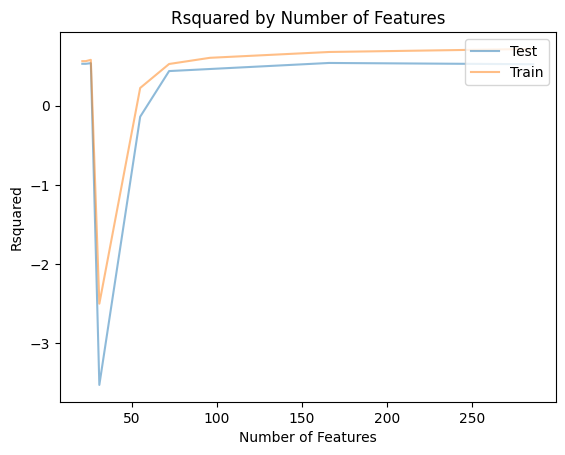

166
0.5402060810589937
0.6788310659795831


In [9]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 25, 10, 5]

print("weekly price prediction")

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X_weekly, y_weekly, cutoffs)

print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2


In [10]:
coef_df_price = coef_weights(lm_model.coef_, X_train)

coef_df_price.head(30)

,est_int,coefs,abs_coefs
1,host_acceptance_rate,-1.045081e+15,1.045081e+15
103,first_review_2015-08-23,6.179293e+02,6.179293e+02
73,room_type_Shared room,-4.439209e+02,4.439209e+02
44,"host_verifications_['email', 'phone', 'faceboo...",4.267064e+02,4.267064e+02
32,host_since_2013-08-30,3.560926e+02,3.560926e+02
28,host_since_2012-01-18,2.823443e+02,2.823443e+02
62,host_has_profile_pic_t,-2.683703e+02,2.683703e+02
91,calendar_updated_6 months ago,1.978026e+02,1.978026e+02
121,last_review_2015-11-08,-1.794607e+02,1.794607e+02
136,last_review_2015-12-08,-1.756934e+02,1.756934e+02


We can see here that the most important factor is still the host acceptance rate. 
But now some new factors come into play; the host verifications, the property type 
(apparently people wont pay as much for a week in a shared room or private room in someones house, and 
also the number of bedrooms and bathrooms come into play).

monthly price prediction


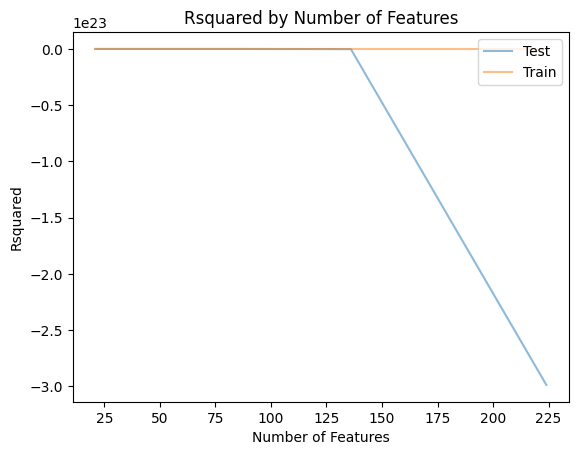

22
0.37519860442668973
0.5341267401306022


In [11]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 25, 10, 5]

print("monthly price prediction")

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X_monthly, y_monthly, cutoffs)

print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2


In [12]:
coef_df_price = coef_weights(lm_model.coef_, X_train)

coef_df_price.head(30)

,est_int,coefs,abs_coefs
3,accommodates,4.067445e+02,4.067445e+02
21,review_scores_value,-3.392586e+02,3.392586e+02
20,review_scores_location,3.091102e+02,3.091102e+02
19,review_scores_communication,-2.019401e+02,2.019401e+02
18,review_scores_checkin,1.519200e+02,1.519200e+02
17,review_scores_cleanliness,1.117871e+02,1.117871e+02
16,review_scores_accuracy,1.104808e+02,1.104808e+02
15,review_scores_rating,2.579452e+01,2.579452e+01
6,cleaning_fee,1.227007e+01,1.227007e+01
7,extra_people,1.134097e+01,1.134097e+01


We have some new info when looking predicting the monthly price we can see the most important factor is number 
of people that the rental accomodates (I guess people don’t like to vacation alone after all). 
For this prediction the review scores for different types of reviews (location, communication, etc.) 
start to come into play.